In [1]:
!nvidia-smi  #monitors and manages NVIDIA GPUs such as Tesla, Quadro, GRID, and GeForce.

Wed Jul 12 08:37:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

TensorFlow: free and open-source software library for machine learning and artificial intelligence. Numpy: #library for python arrays and matrices Matplotlib.pyplot: #matplotlib.pyplot is a plotting library used for 2D graphics in python programming language Random: #bulit-in random function for generating random numbers math: #built-in math function os: #used for interacting with operating systems cv2: #library used to solve computer vision problems sklearn.linear_model: #it is a python machine learning library, it offers a variety of effective tools for statistical modeling and machine learning including classification, regression, clustering, and dimensionality reduction. sklearn.preprocessing: #refers to the transformations applied to the data before feeding it to algorithm PolynomailFeatures: #sklearn.preprocessing.PolynomialFeatures Generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree. StandardScaler: #function to standardize the data values into a standard format. LabelEncoder: # Sklearn provides a very efficient tool for encoding the levels of a categorical features into numeric values. LabelEncoder encode labels with value between 0 and n_classes-1. Like male-->0, female-->1 train_test_split: Train test split is a model validation process that allows you to simulate how your model would perform with new data.



In [2]:
#importing libraries to be used
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import joblib
import os
import cv2 as cv
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

##**Data Gathering and Preprocessing**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!git clone https://github.com/cardstdani/WasteClassificationNeuralNetwork.git #This is transfer Learning: Feature extraction

Cloning into 'WasteClassificationNeuralNetwork'...
remote: Enumerating objects: 5092, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 5092 (delta 10), reused 23 (delta 9), pack-reused 5068
Receiving objects: 100% (5092/5092), 223.89 MiB | 17.95 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Updating files: 100% (5082/5082), done.


In [5]:
from PIL import Image
import numpy as np
import os, os.path, time

format='.jpg'
myDir = "/content/drive/MyDrive/FYP/Datasets/Dt3_six_clear_category/Garbage classification/Garbage classification"
def createFileList(myDir, format='.jpg'):    #data is appended in a file from drive
    fileList = []
    print(myDir)
    for root, dirs, files in os.walk(myDir, topdown=False):
            for name in files:
               if name.endswith(format):
                  fullName = os.path.join(root, name)
                  fileList.append(fullName)
                  return fileList



In [6]:
#LOAD DATA
DIR = "/content/drive/MyDrive/FYP/Datasets/Dt3_six_clear_category/Garbage classification/Garbage classification"
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="training",  seed=42, batch_size=128,smart_resize=True, image_size=(256, 256))
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(DIR, validation_split=0.1, subset="validation", seed=42, batch_size=128, smart_resize=True, image_size=(256, 256))

classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 2993 files belonging to 7 classes.
Using 2694 files for training.
Found 2993 files belonging to 7 classes.
Using 299 files for validation.
['battery', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


##**Model Training**

In [7]:
baseModel = tf.keras.applications.MobileNetV3Large(input_shape=(256, 256,3), weights='imagenet', include_top=False, classes=numClasses)
for layers in baseModel.layers[:-6]:
  layers.trainable=False

last_output = baseModel.layers[-1].output
x = tf.keras.layers.Dropout(0.45) (last_output)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization() (x)
x = tf.keras.layers.Dense(256, activation = tf.keras.activations.elu, kernel_regularizer=tf.keras.regularizers.l1(0.045), activity_regularizer=tf.keras.regularizers.l1(0.045),  kernel_initializer='he_normal')(x)
x = tf.keras.layers.Dropout(0.45) (x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input,outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00125), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

epochs = 50
lrCallback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch / 30))
stepDecay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.1 * 0.1**math.floor(epoch / 6))
history = model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, callbacks=[])

12683000/12683000 [==============================] - 2s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


22/22 [==============================] - 907s 26s/step - loss: 308.0727 - accuracy: 0.5334 - val_loss: 191.5212 - val_accuracy: 0.7726
Epoch 2/50
22/22 [==============================] - 12s 354ms/step - loss: 127.5477 - accuracy: 0.7854 - val_loss: 68.0115 - val_accuracy: 0.8428
Epoch 3/50
22/22 [==============================] - 11s 400ms/step - loss: 39.9014 - accuracy: 0.8330 - val_loss: 17.0306 - val_accuracy: 0.8294
Epoch 4/50
22/22 [==============================] - 11s 385ms/step - loss: 9.9870 - accuracy: 0.7895 - val_loss: 6.2566 - val_accuracy: 0.6388
Epoch 5/50
22/22 [==============================] - 11s 410ms/step - loss: 5.0328 - accuracy: 0.7491 - val_loss: 4.4636 - val_accuracy: 0.6154
Epoch 6/50
22/22 [==============================] - 10s 335ms/step - loss: 4.1785 - accuracy: 0.7442 - val_loss: 4.2234 - val_accuracy: 0.5920
Epoch 7/50
22/22 [==============================] - 11s 337ms/step - loss: 4.0490 - accuracy: 0.7335 - val_loss: 4.1107 - val_accuracy: 0.6254
Ep

In [8]:
#saving model
import pickle
with open('model_pickle','wb') as f:
  pickle.dump(model,f)

In [9]:
model.save("/content/drive/MyDrive/FYP/model.h5")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 128, 128, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                              

##**Model Evaluation**

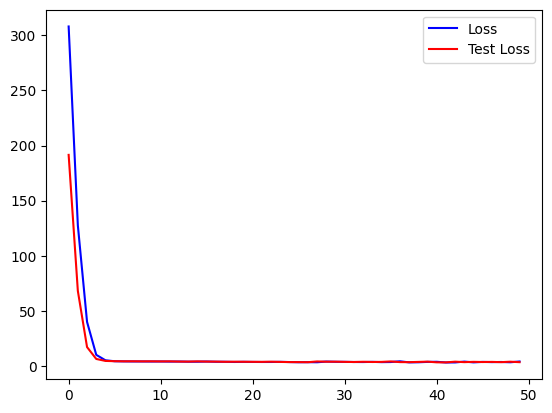

In [10]:
plt.plot(range(0, epochs), history.history["loss"], color="b", label="Loss")
plt.plot(range(0, epochs), history.history["val_loss"], color="r", label="Test Loss")
plt.legend()
plt.show()

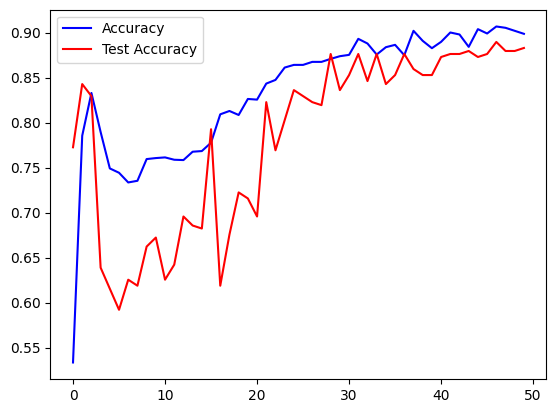

In [11]:
plt.plot(range(0, epochs), history.history["accuracy"], color="b", label="Accuracy")
plt.plot(range(0, epochs), history.history["val_accuracy"], color="r", label="Test Accuracy")
plt.legend()
plt.show()

Text(0, 0.5, 'Loss')

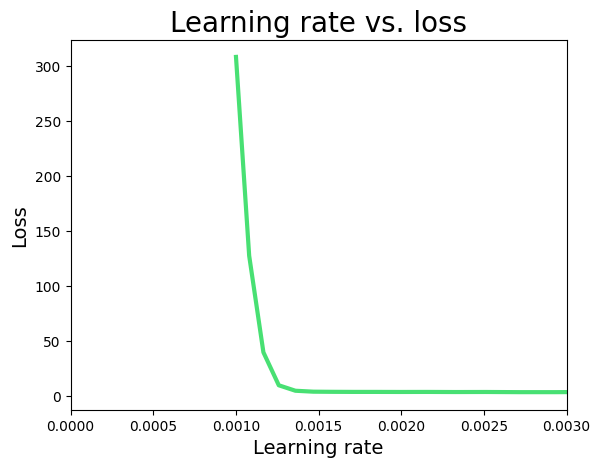

In [12]:
plt.xlim([0, 0.003])
learning_rates = 1e-3 * (10 ** (np.arange(epochs) / 30))
plt.plot(learning_rates, history.history['loss'], lw=3, color='#48e073')
plt.title('Learning rate vs. loss', size=20)
plt.xlabel('Learning rate', size=14)
plt.ylabel('Loss', size=14)

1/1 [==============================] - 4s 4s/step
[ 5.313991   1.4394567 75.35297   10.048851   1.2703795  5.034984
  1.539373 ] 
 ['battery', 'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Prediction:  glass 75.35296678543091%


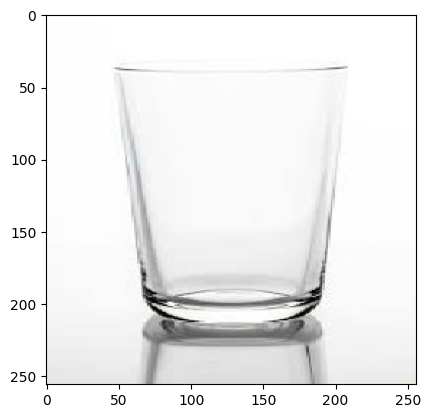

In [14]:
#import requests

#img_data = requests.get("https://images.unsplash.com/photo-1591872203534-278fc084969e?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1064&q=80").content
#with open('img.jpg', 'wb') as handler:
 #   handler.write(img_data)

path = "p2.jpg"

img = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

plt.imshow(img)
print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

1/1 [==============================] - 0s 38ms/step


<Figure size 1000x1000 with 0 Axes>

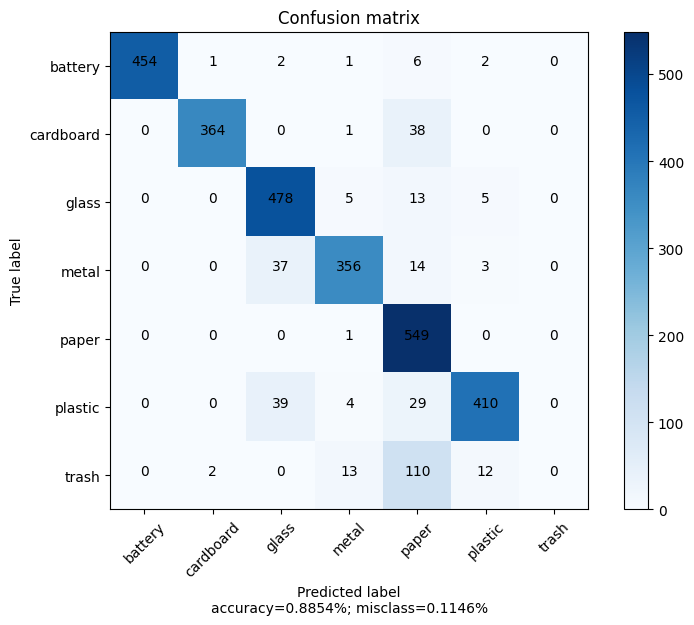

In [15]:
def plot_confusion_matrix(cm, target_names, cmap=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}%; misclass={:0.4f}%'.format(accuracy, misclass))
    plt.show()

plt.figure(figsize=(10, 10))
true = []
predictions = []

"""
for images, labels in test_dataset.take(50):
  pred = model.predict(images)
  for i in range(32):
    try:
      ax = plt.subplot(4, 8, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      #print(classes[np.argmax(pred[i])], 100 * np.max(pred[i]), "real = " + str(classes[labels[i]]))

      true.append(labels[i])
      predictions.append(np.argmax(pred[i]))

      plt.title(classes[labels[i]])
      plt.axis("off")
    except:
      print()

"""
path = "/content/drive/MyDrive/FYP/Datasets/Dt3_six_clear_category/Garbage classification/Garbage classification"
for i in os.listdir(path):
  folderPath = os.path.join(path, i)
  for j in os.listdir(folderPath)[:550]:
    fullPath = os.path.join(folderPath, j)
    try:
      img = tf.keras.preprocessing.image.load_img(fullPath, target_size=(256, 256))
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_array = tf.expand_dims(img_array, 0)

      preds = model.predict(img_array)
      true.append(classes.index(i))
      predictions.append(np.argmax(preds))
    except:
      print("Error on image:", fullPath)

plot_confusion_matrix(tf.math.confusion_matrix(true, predictions), classes)

**Advanced Filter Visualization**

1/1 [==============================] - 0s 55ms/step


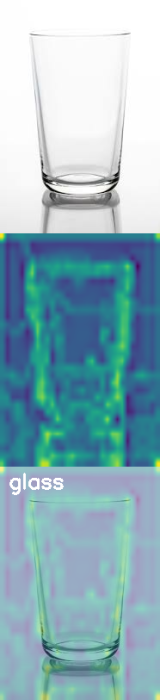

In [17]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import imutils

class GradCAM:
  def __init__(self, model, classIdx, layerName=None):
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
    if self.layerName is None:
      self.layerName = self.find_target_layer()

  def find_target_layer(self):
    for layer in reversed(self.model.layers):
      if len(layer.output_shape) == 4:
        return layer.name
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

  def compute_heatmap(self, image, eps=1e-8):
    gradModel = Model(
			inputs=[self.model.inputs],
			outputs=[self.model.get_layer(self.layerName).output,
				self.model.output])
    with tf.GradientTape() as tape:
      inputs = tf.cast(image, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, self.classIdx]
    grads = tape.gradient(loss, convOutputs)
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    return heatmap

  def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    return (heatmap, output)

path = "p2.jpg"
orig = cv2.imread(path)
resized = cv2.resize(orig, (256, 256))

image = tf.keras.preprocessing.image.load_img(path, target_size=(256, 256))
image = tf.keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)

predictions = model.predict(image)
cam = GradCAM(model, np.argmax(predictions[0]), "expanded_conv_6/expand")
heatmap = cv2.resize(cam.compute_heatmap(image), (orig.shape[1], orig.shape[0]))

#heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
(heatmap, output) = cam.overlay_heatmap(heatmap, orig, alpha=0.5)

#cv2.rectangle(output, (0, 0), (340, 40), (0, 0, 0), -1)
cv2.putText(output, classes[np.argmax(predictions)], (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

output = np.vstack([orig, heatmap, output])
output = imutils.resize(output, height=700)
cv2_imshow(output)

In [18]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)
